Chuẩn bị dữ liệu

In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA giảm chiều (ví dụ giữ 95% variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Số thành phần PCA giữ lại: {X_pca.shape[1]}")

# Train/test split
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

ValueError: could not convert string to float: 'Dự án The Empire - Vinhomes Ocean Park 2, Xã Long Hưng, Văn Giang, Hưng Yên'

In [2]:
file_path = 'data/vietnam_housing_dataset.csv'
house_data = pd.read_csv(file_path)
house_data.head()

,Address,Area,Frontage,Access Road,House direction,Balcony direction,Floors,Bedrooms,Bathrooms,Legal status,Furniture state,Price
0,"Dự án The Empire - Vinhomes Ocean Park 2, Xã L...",84.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,Have certificate,NaN,8.60
1,"Dự án The Crown - Vinhomes Ocean Park 3, Xã Ng...",60.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,7.50
2,"Dự án The Crown - Vinhomes Ocean Park 3, Xã Ng...",90.0,6.0,13.0,Đông - Bắc,Đông - Bắc,5.0,NaN,NaN,Sale contract,NaN,8.90
3,"Đường Nguyễn Văn Khối, Phường 11, Gò Vấp, Hồ C...",54.0,NaN,3.5,Tây - Nam,Tây - Nam,2.0,2.0,3.0,Have certificate,Full,5.35
4,"Đường Quang Trung, Phường 8, Gò Vấp, Hồ Chí Minh",92.0,NaN,NaN,Đông - Nam,Đông - Nam,2.0,4.0,4.0,Have certificate,Full,6.90


<Axes: xlabel='Price', ylabel='Count'>

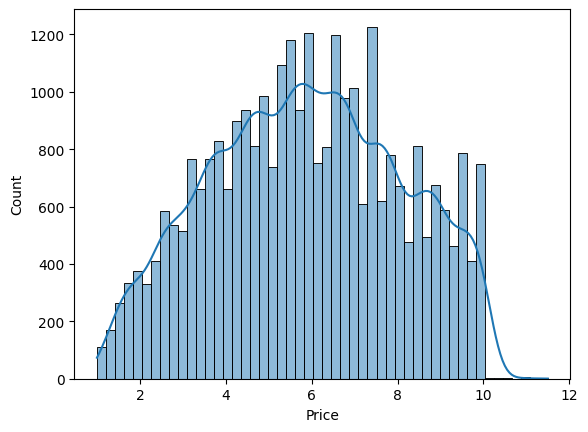

In [3]:
sns.histplot(house_data['Price'], kde=True)

In [ ]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Đọc CSV
df = pd.read_csv("/housing_processed.csv")

# Chia cột
num_cols = ['Area','Frontage','Access Road','Floors','Bedrooms','Bathrooms']
cat_cols = ['Address','House direction','Balcony direction','Legal status','Furniture state']

X = df[num_cols + cat_cols]
y = df['Price']

# Numeric pipeline: impute + scale
numeric_preprocess = Pipeline([
    ("imputer", IterativeImputer(random_state=42)),
    ("scaler", StandardScaler())
])

# Categorical pipeline: fillna + onehot
categorical_preprocess = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Kết hợp
preprocess = ColumnTransformer([
    ("num", numeric_preprocess, num_cols),
    ("cat", categorical_preprocess, cat_cols)
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def fit_eval(pipe, X_train, y_train, X_test, y_test, name="Model"):
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
    mape = float(mean_absolute_percentage_error(y_test, y_pred)) * 100
    print(f"{name}: RMSE={rmse:.4f} | MAPE={mape:.2f}%")
    return rmse, mape

# ----- Ridge -----
ridge_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", Ridge())
])

ridge_gs = GridSearchCV(
    ridge_pipe,
    param_grid={"model__alpha": [0.01, 0.1, 1, 10, 100]},
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

ridge_rmse, ridge_mape = fit_eval(ridge_gs, X_train, y_train, X_test, y_test, "Ridge (GridSearch)")
print("  -> Best alpha (Ridge):", ridge_gs.best_params_["model__alpha"])

# ----- Lasso -----
lasso_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", Lasso(max_iter=10000, tol=1e-3))
])

lasso_gs = GridSearchCV(
    lasso_pipe,
    param_grid={"model__alpha": [0.001, 0.01, 0.1, 1, 10]},
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

lasso_rmse, lasso_mape = fit_eval(lasso_gs, X_train, y_train, X_test, y_test, "Lasso (GridSearch)")
print("  -> Best alpha (Lasso):", lasso_gs.best_params_["model__alpha"])


Ridge (GridSearch): RMSE=1.6541 | MAPE=28.15%
  -> Best alpha (Ridge): 1
Lasso (GridSearch): RMSE=1.9093 | MAPE=35.40%
  -> Best alpha (Lasso): 0.001


In [17]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline

# Pipeline XGB
xgb_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    ))
])

# Grid mở rộng
param_grid = {
    "model__n_estimators": [800, 1000, 1200],
    "model__max_depth": [5, 7, 9],
    "model__learning_rate": [0.01, 0.03, 0.1],
    "model__subsample": [0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.7, 1.0],
    "model__gamma": [0, 0.1, 0.2],
    "model__reg_lambda": [1.0, 3.0]
}

xgb_gs = GridSearchCV(
    xgb_pipe,
    param_grid=param_grid,
    cv=3,  # để đỡ nặng, bạn có thể tăng lên 5 nếu máy mạnh
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

# Train & evaluate
xgb_gs.fit(X_train, y_train)
y_pred = xgb_gs.predict(X_test)

xgb_rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
xgb_mape = float(mean_absolute_percentage_error(y_test, y_pred) * 100)

print(f"XGB (GridSearch mở rộng): RMSE={xgb_rmse:.4f} | MAPE={xgb_mape:.2f}%")
print("  -> Best params:", xgb_gs.best_params_)


Fitting 3 folds for each of 972 candidates, totalling 2916 fits
XGB (GridSearch mở rộng): RMSE=1.6053 | MAPE=27.54%
  -> Best params: {'model__colsample_bytree': 0.7, 'model__gamma': 0, 'model__learning_rate': 0.1, 'model__max_depth': 9, 'model__n_estimators': 1200, 'model__reg_lambda': 1.0, 'model__subsample': 0.8}


PCA-DNN


In [8]:
# 0) Chuẩn bị
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np, tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42); np.random.seed(42)

# 1) Fit preprocess trên train, transform ra ma trận (sparse)
preprocess.fit(X_train, y_train)
X_train_proc = preprocess.transform(X_train)   # sparse
X_test_proc  = preprocess.transform(X_test)    # sparse

# 2) Giảm chiều bằng TruncatedSVD (làm việc trực tiếp với sparse)
svd = TruncatedSVD(n_components=256, random_state=42)
X_train_svd = svd.fit_transform(X_train_proc)
X_test_svd  = svd.transform(X_test_proc)

# 3) Build & train DNN "thuần" Keras
model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train_svd.shape[1],)),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")

es = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    X_train_svd, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=0,
    callbacks=[es]
)

# 4) Đánh giá
y_pred = model.predict(X_test_svd, verbose=0).ravel()
rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
mape = float(mean_absolute_percentage_error(y_test, y_pred) * 100)
print(f"SVD-DNN (keras thuần): RMSE={rmse:.4f} | MAPE={mape:.2f}%")


c:\Users\xamth\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


SVD-DNN (keras thuần): RMSE=1.7744 | MAPE=30.92%


In [8]:
# ==== DNN không PCA/SVD ====
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.sparse import issparse

tf.random.set_seed(42); np.random.seed(42)

# 1) Fit preprocess trên train, rồi transform
preprocess.fit(X_train, y_train)
X_train_proc = preprocess.transform(X_train)   # thường là sparse CSR
X_test_proc  = preprocess.transform(X_test)

# 2) Convert sang dense cho Keras
def to_dense_float32(X):
    if issparse(X):
        X = X.toarray()
    return X.astype(np.float32, copy=False)

X_train_dense = to_dense_float32(X_train_proc)
X_test_dense  = to_dense_float32(X_test_proc)
y_train_arr   = np.asarray(y_train, dtype=np.float32)
y_test_arr    = np.asarray(y_test,  dtype=np.float32)

print("Dense shapes:", X_train_dense.shape, X_test_dense.shape)

# 3) Build DNN
def build_dnn(input_dim, hidden1=256, hidden2=128, dropout=0.2, lr=1e-3):
    model = Sequential([
        Dense(hidden1, activation="relu", input_shape=(input_dim,)),
        Dropout(dropout),
        Dense(hidden2, activation="relu"),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss="mse")
    return model

model = build_dnn(X_train_dense.shape[1], hidden1=256, hidden2=128, dropout=0.25, lr=1e-3)

# 4) Train với EarlyStopping
es = EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss")
history = model.fit(
    X_train_dense, y_train_arr,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    verbose=1,
    callbacks=[es]
)

# 5) Đánh giá
y_pred = model.predict(X_test_dense, verbose=0).ravel()
rmse = float(np.sqrt(mean_squared_error(y_test_arr, y_pred)))
mape = float(mean_absolute_percentage_error(y_test_arr, y_pred) * 100)
print(f"DNN (no PCA/SVD): RMSE={rmse:.4f} | MAPE={mape:.2f}%")


Dense shapes: (24184, 8905) (6046, 8905)


c:\Users\xamth\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
303/303 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 10.0763 - val_loss: 3.0748
Epoch 2/150
303/303 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 2.8508 - val_loss: 2.7322
Epoch 3/150
303/303 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 2.1192 - val_loss: 2.7508
Epoch 4/150
303/303 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 1.7401 - val_loss: 2.7406
Epoch 5/150
303/303 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 1.4948 - val_loss: 2.6259
Epoch 6/150
303/303 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 1.3835 - val_loss: 2.5394
Epoch 7/150
303/303 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 1.2945 - val_loss: 2.5324
Epoch 8/150
303/303 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 1.2104 - val_loss: 2.5935
Epoch 9/150
303/303 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 1.1541 - val_loss: 2.5449
Epoch 10/150
303/303 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 1.1581 - val_loss: 2.5241
Epoch 11/150
303/303 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 1.0978 - val_loss: 2.4903
Epoch 12/150
303/303 ━━━━━━━━

Train Model

In [4]:
import numpy as np, tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.sparse import issparse

tf.random.set_seed(42); np.random.seed(42)

# 1) Fit preprocess trên TRAIN, rồi transform
preprocess.fit(X_train, y_train)
X_train_proc = preprocess.transform(X_train)
X_test_proc  = preprocess.transform(X_test)

# 2) Chuyển sang dense cho Keras
def to_dense_float32(X):
    if issparse(X): X = X.toarray()
    return X.astype(np.float32, copy=False)

X_train_dense = to_dense_float32(X_train_proc)
X_test_dense  = to_dense_float32(X_test_proc)
y_train_arr   = np.asarray(y_train, dtype=np.float32)
y_test_arr    = np.asarray(y_test,  dtype=np.float32)

# 3) Build & train
def build_dnn(input_dim, hidden1=256, hidden2=128, dropout=0.25, lr=1e-3):
    model = Sequential([
        Dense(hidden1, activation="relu", input_shape=(input_dim,)),
        Dropout(dropout),
        Dense(hidden2, activation="relu"),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss="mse")
    return model

model = build_dnn(X_train_dense.shape[1])
es = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(
    X_train_dense, y_train_arr,
    validation_split=0.2,
    epochs=150, batch_size=64, verbose=0,
    callbacks=[es]
)

# 4) Đánh giá + xem thử vài mẫu
y_pred = model.predict(X_test_dense, verbose=0).ravel()
rmse = float(np.sqrt(mean_squared_error(y_test_arr, y_pred)))
mape = float(mean_absolute_percentage_error(y_test_arr, y_pred) * 100)
print(f"DNN (no PCA/SVD): RMSE={rmse:.4f} | MAPE={mape:.2f}%")

print("\nSample predictions:")
for i in range(5):
    idx = X_test.index[i]
    print(f"- id={idx}: true={y_test_arr[i]:.3f} | pred={y_pred[i]:.3f}")


c:\Users\xamth\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


DNN (no PCA/SVD): RMSE=1.5769 | MAPE=25.60%

Sample predictions:
- id=30212: true=1.400 | pred=3.575
- id=28363: true=8.000 | pred=6.229
- id=19706: true=5.900 | pred=4.828
- id=3594: true=5.650 | pred=6.275
- id=17626: true=8.900 | pred=6.879


Stacking

In [13]:
# pip install xgboost  # nếu chưa có
import xgboost as xgb
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers, optimizers
def build_xgb_model(params=None):
    """
    Trả về XGBRegressor với bộ tham số 'ổn định' mặc định cho tabular data.
    Bạn có thể truyền dict params để ghi đè.
    """
    default_params = dict(
        n_estimators=2000,         # nhiều cây + early stopping để dừng sớm ở vòng tốt nhất
        learning_rate=0.03,        # LR thấp cho ổn định
        max_depth=6,               # độ sâu vừa phải
        subsample=0.8,             # chống overfit
        colsample_bytree=0.8,      # chống overfit
        min_child_weight=1.5,      # tăng nhẹ regularization
        reg_alpha=0.0,             # L1
        reg_lambda=1.0,            # L2
        gamma=0.0,
        tree_method="hist",        # nhanh, ổn định
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )
    if params is not None:
        default_params.update(params)
    return xgb.XGBRegressor(**default_params)

def fit_xgb_with_es(model, X_tr, y_tr, X_va, y_va, es_rounds=100, verbose=False):
    """
    Train XGB với early stopping trên tập validation.
    Trả về model đã fit; best_iteration sẽ được lưu nội bộ trong model.
    """
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_va, y_va)],
        eval_metric="rmse",
        verbose=verbose,
        early_stopping_rounds=es_rounds
    )
    return model


def build_dnn(input_dim, hidden=(256, 128, 64), dropout=0.2, l2=1e-4, lr=1e-3):
    inputs = keras.Input(shape=(input_dim,))
    x = inputs
    for h in hidden:
        x = layers.Dense(h, activation="relu",
                         kernel_regularizer=regularizers.l2(l2))(x)
        x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1)(x)  # hồi quy
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss="mse",
                  metrics=["mae"])
    return model

early_stopping = callbacks.EarlyStopping(monitor="val_loss",
                                         patience=10,
                                         restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss",
                                        factor=0.5,
                                        patience=5,
                                        min_lr=1e-6)


prepare dataset

In [33]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# ===== 1. Đọc dữ liệu =====
df = pd.read_csv("housing_processed.csv")

# Chuẩn hoá tên cột (xóa khoảng trắng, ký tự lạ)
df.columns = (
    df.columns.str.strip()
              .str.replace(r"\s+", " ", regex=True)
              .str.replace(":", "", regex=False)
)

# Bỏ cột Address (văn bản dài)
if "Address" in df.columns:
    df = df.drop(columns=["Address"])

# ===== 2. Ép kiểu số cho các cột có thể bị lẫn chuỗi =====
num_cols = ["Area", "Frontage", "Access Road", "Floors", "Bedrooms", "Bathroom", "Price"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# ===== 3. Xác định cột numeric & categorical =====
target = "Price"
num_cols = [c for c in df.select_dtypes(include=["number"]).columns if c != target]
cat_cols = [c for c in df.columns if c not in num_cols + [target]]

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# ===== 4. Xử lý thiếu & chia tập =====
df = df.dropna(subset=[target])
X = df[num_cols + cat_cols]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ===== 5. Pipelines tiền xử lý =====
numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# tương thích sklearn >= 1.4
def make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", make_ohe())
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, num_cols),
        ("cat", categorical_preprocess, cat_cols),
    ],
    remainder="drop"
)

# ===== 6. Fit/transform (fit trên train) =====
preprocess_fitted = preprocess.fit(X_train)
X_train_enc = preprocess_fitted.transform(X_train)
X_test_enc  = preprocess_fitted.transform(X_test)

print("Encoded train shape:", X_train_enc.shape)
print("Encoded test shape:", X_test_enc.shape)


Numeric columns: ['Area', 'Frontage', 'Access Road', 'Floors', 'Bedrooms', 'Bathrooms']
Categorical columns: ['House direction', 'Balcony direction', 'Legal status', 'Furniture state', 'District', 'City']
Encoded train shape: (24184, 391)
Encoded test shape: (6046, 391)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# ===== 1. Đọc dữ liệu =====
df = pd.read_csv("housing_processed.csv")

# Chuẩn hoá tên cột (xóa khoảng trắng, ký tự lạ)
df.columns = (
    df.columns.str.strip()
              .str.replace(r"\s+", " ", regex=True)
              .str.replace(":", "", regex=False)
)

# Bỏ cột Address (văn bản dài)
if "Address" in df.columns:
    df = df.drop(columns=["Address"])

# ===== 2. Ép kiểu số cho các cột có thể bị lẫn chuỗi =====
num_cols = ["Area", "Frontage", "Access Road", "Floors", "Bedrooms", "Bathroom", "Price"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# ===== 3. Xác định cột numeric & categorical =====
target = "Price"
num_cols = [c for c in df.select_dtypes(include=["number"]).columns if c != target]
cat_cols = [c for c in df.columns if c not in num_cols + [target]]

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# ===== 4. Xử lý thiếu & chia tập =====
df = df.dropna(subset=[target])
X = df[num_cols + cat_cols]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ===== 5. Pipelines tiền xử lý =====
numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# tương thích sklearn >= 1.4
def make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", make_ohe())
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, num_cols),
        ("cat", categorical_preprocess, cat_cols),
    ],
    remainder="drop"
)

# ===== 6. Fit/transform (fit trên train) =====
preprocess_fitted = preprocess.fit(X_train)
X_train_enc = preprocess_fitted.transform(X_train)
X_test_enc  = preprocess_fitted.transform(X_test)

print("Encoded train shape:", X_train_enc.shape)
print("Encoded test shape:", X_test_enc.shape)


Numeric columns: ['Area', 'Frontage', 'Access Road', 'Floors', 'Bedrooms', 'Bathrooms']
Categorical columns: ['House direction', 'Balcony direction', 'Legal status', 'Furniture state', 'District', 'City']
Encoded train shape: (24184, 391)
Encoded test shape: (6046, 391)


In [40]:
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge

# ---------- Helpers ----------
def eval_rmse_mape(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = 100 * mean_absolute_percentage_error(y_true, y_pred)
    return rmse, mape

# ---------- DNN ----------
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers, optimizers

def build_dnn(input_dim, hidden=(256,128,64), dropout=0.2, l2=1e-4, lr=1e-3):
    inp = keras.Input(shape=(input_dim,))
    x = inp
    for h in hidden:
        x = layers.Dense(h, activation="relu",
                         kernel_regularizer=regularizers.l2(l2))(x)
        x = layers.Dropout(dropout)(x)
    out = layers.Dense(1)(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss="mse", metrics=["mae"])
    return model

early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)

# ---------- XGB ----------
import xgboost as xgb

def build_xgb_model(params=None):
    default_params = dict(
        n_estimators=2000,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=1.5,
        reg_lambda=1.0,
        tree_method="hist",
        objective="reg:squarederror",
        eval_metric="rmse",          # XGBoost >=2.0: khai báo ở constructor
        early_stopping_rounds=100,   # và cả early stopping ở đây
        random_state=42,
        n_jobs=-1
    )
    if params: default_params.update(params)
    return xgb.XGBRegressor(**default_params)

def fit_xgb_with_es(model, X_tr, y_tr, X_va, y_va, verbose=False):
    # XGBoost >=2.0: .fit() KHÔNG nhận early_stopping_rounds, chỉ cần eval_set
    model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=verbose)
    return model

# ===========================================================
# 1) OOF predictions cho stacking
# ===========================================================
Xarr = np.asarray(X_train_enc)
yarr = np.asarray(y_train).ravel()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_dnn = np.zeros(len(Xarr))
oof_xgb = np.zeros(len(Xarr))

for tr_idx, va_idx in kf.split(np.arange(len(Xarr))):
    X_tr, X_va = Xarr[tr_idx], Xarr[va_idx]
    y_tr, y_va = yarr[tr_idx], yarr[va_idx]

    # DNN
    dnn = build_dnn(input_dim=X_tr.shape[1])
    dnn.fit(X_tr.astype("float32"), y_tr.astype("float32"),
            validation_data=(X_va.astype("float32"), y_va.astype("float32")),
            epochs=200, batch_size=64, callbacks=[early_stopping, reduce_lr],
            verbose=0)
    oof_dnn[va_idx] = dnn.predict(X_va, verbose=0).ravel()

    # XGB
    xgbm = build_xgb_model()
    xgbm = fit_xgb_with_es(xgbm, X_tr, y_tr, X_va, y_va, verbose=False)
    oof_xgb[va_idx] = xgbm.predict(X_va).ravel()

# OOF metrics (đúng tên biến)
rmse_dnn_oof,  mape_dnn_oof  = eval_rmse_mape(yarr, oof_dnn)
rmse_xgb_oof,  mape_xgb_oof  = eval_rmse_mape(yarr, oof_xgb)
print(f"OOF DNN -> RMSE={rmse_dnn_oof:.4f} | MAPE={mape_dnn_oof:.2f}%")
print(f"OOF XGB -> RMSE={rmse_xgb_oof:.4f} | MAPE={mape_xgb_oof:.2f}%")

# Ma trận đặc trưng cho meta model
Z_train = np.vstack([oof_dnn, oof_xgb]).T
print("Z_train shape:", Z_train.shape)

# ===========================================================
# 2) Meta-model (Ridge) huấn luyện trên OOF
# ===========================================================
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

meta = GridSearchCV(
    Ridge(),
    param_grid={"alpha": [0.01, 0.1, 1.0, 3.0, 10.0]},
    cv=5,
    scoring="neg_root_mean_squared_error"
)
meta.fit(Z_train, yarr)
print("Meta best alpha:", meta.best_params_, "| cv RMSE:", -meta.best_score_)

# ===========================================================
# 3) Refit base models trên FULL TRAIN và đánh giá TEST
# ===========================================================
Xtr_full = Xarr
ytr_full = yarr
Xte_full = np.asarray(X_test_enc)
yte_full = np.asarray(y_test).ravel()

# DNN full
dnn_full = build_dnn(input_dim=Xtr_full.shape[1])
dnn_full.fit(Xtr_full.astype("float32"), ytr_full.astype("float32"),
             validation_split=0.1,
             epochs=200, batch_size=64,
             callbacks=[early_stopping, reduce_lr],
             verbose=0)
p_dnn_test = dnn_full.predict(Xte_full, verbose=0).ravel()
rmse_dnn_test, mape_dnn_test = eval_rmse_mape(yte_full, p_dnn_test)
print(f"[TEST] DNN   -> RMSE={rmse_dnn_test:.4f} | MAPE={mape_dnn_test:.2f}%")

# XGB full
xgb_full = build_xgb_model()
xgb_full = fit_xgb_with_es(xgb_full, Xtr_full, ytr_full, Xte_full, yte_full, verbose=False)
p_xgb_test = xgb_full.predict(Xte_full).ravel()
rmse_xgb_test, mape_xgb_test = eval_rmse_mape(yte_full, p_xgb_test)
print(f"[TEST] XGB   -> RMSE={rmse_xgb_test:.4f} | MAPE={mape_xgb_test:.2f}%")

# Stacking trên TEST
Z_test = np.vstack([p_dnn_test, p_xgb_test]).T
p_stack_test = meta.best_estimator_.predict(Z_test).ravel()
rmse_stack_test, mape_stack_test = eval_rmse_mape(yte_full, p_stack_test)
print(f"[TEST] STACK -> RMSE={rmse_stack_test:.4f} | MAPE={mape_stack_test:.2f}%")

# (Tùy chọn) Weighted Average
ws = np.linspace(0, 1, 41)
best = None
for w in ws:
    pred = w*p_dnn_test + (1-w)*p_xgb_test
    rmse, mape = eval_rmse_mape(yte_full, pred)
    if (best is None) or (rmse < best[0]):
        best = (rmse, mape, w)
print(f"[TEST] WeightedAvg best w(DNN)={best[2]:.3f} -> RMSE={best[0]:.4f} | MAPE={best[1]:.2f}%")


OOF DNN -> RMSE=1.3677 | MAPE=20.68%
OOF XGB -> RMSE=1.3106 | MAPE=20.37%
Z_train shape: (24184, 2)
Meta best alpha: {'alpha': 10.0} | cv RMSE: 1.3056358748140833
[TEST] DNN   -> RMSE=1.3844 | MAPE=21.04%
[TEST] XGB   -> RMSE=1.3415 | MAPE=21.05%
[TEST] STACK -> RMSE=1.3339 | MAPE=20.76%
[TEST] WeightedAvg best w(DNN)=0.275 -> RMSE=1.3341 | MAPE=20.74%


In [ ]:
import joblib
import xgboost as xgb

# 1️ Tiền xử lý (ColumnTransformer)
joblib.dump(preprocess_fitted, "preprocess.pkl")

# 2️ DNN (Keras Model)
dnn_full.save("dnn_full.keras")   # TensorFlow 2.x format (ổn định, portable)

# 3️ XGB
xgb_full.save_model("xgb_full.json")

# 4️ Meta-model (Ridge cho stacking)
joblib.dump(meta.best_estimator_, "meta_ridge.pkl")

print(" Saved all models: preprocess.pkl, dnn_full.keras, xgb_full.json, meta_ridge.pkl")


 Saved all models: preprocess.pkl, dnn_full.keras, xgb_full.json, meta_ridge.pkl
